<div class="alert alert-success">
<b>КОММЕНТАРИЙ V4</b> 	

1. Код посмотрел. Всё отлично, всё поправлено!
    
2. Меня смущает то, что что после того как ты получил гиперпараметры самой лучшей модели на кросс-валидации ты вновь занимаешся подбором гиперпараметров уже для тестовой выборки. На тесте нужно "подтвердить" то, что получено на кросс-валидации. Дополнительное обучение и новый подбор гиперпараметров не нужен. Алексей - давай такое решение примем: чтобы не заходить на 4ю итерацию я твой проект принимаю, но тебя прошу обсудить этот момент с преподавателем. Буду рад оказаться неправым в этом моменте. Если же я всё-таки прав ))), то изменение в коде (перед размещением проекта на Гитхабе) сделать будет легко - удать эту пресловутую ячейку. Хорошо?
</div>

# Определение стоимости автомобилей

## Постановка задачи

**Цель**: Построить модель для определения рыночной стоимости автомобиля.

**Критерии оценки**
1.	качество предсказания;
2.	время обучения модели;
3.	время предсказания модели;

**Критерии успешности** -  метрика *RMSE* < 2500

**Описание данных**

- *Данные:*  `/datasets/autos.csv` 

*Признаки:*
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

*Целевой признак:*
- `Price` — цена (евро)

## План работ

1.	Загрузить данные, путь к файлу: /datasets/autos.csv.
2.	Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах.
3.	Подготовить выборки для обучения моделей.
4.	Обучить разные модели, одна из которых — LightGBM.
5.	Проанализировать время обучения, время предсказания и качество моделей.
6.	Опираясь на критерии заказчика, выберать лучшую модель, проверить её качество на тестовой выборке.


# 1.Обзор данных

## 1.1. Библиотеки

### 1.1.1. Обновление

In [10]:
#!conda install -q phik
#!conda install plotly --upgrade -q
#!conda install --upgrade scikit-learn -q
#!conda install -q mlxtend
#!conda install -q shap
#!conda install matplotlib -q
#!conda install --upgrade imbalanced-learn -q
#!conda install --upgrade matplotlib -q
#!conda install --upgrade pandas numpy -q
#!conda install numpy -q

### 1.1.2. Импорт

In [11]:

# Импорт из стандартной библиотеки
import os  # Функционал ОС (запись файлов, управление директориями и т.п.)
import random
import warnings
from collections import Counter
import re

# Стандартные библиотеки для исследований
import numpy as np
import pandas as pd

# Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shap  # Метод SHAP

# Модели машинного обучения
#from sklearn.dummy import DummyClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Метрики оценки качества модели
from sklearn.metrics import (
#    accuracy_score,
#    classification_report,
#    confusion_matrix,
#    f1_score,
    mean_absolute_error,
    mean_squared_error,
#    precision_score,
#    recall_score,
#    roc_auc_score,
#    roc_curve,
#    precision_recall_curve,
    r2_score,
#    average_precision_score,
#    PrecisionRecallDisplay,
#    ConfusionMatrixDisplay,
    
)

# Предобработка данных
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
 #   LabelEncoder,
 #   OrdinalEncoder,
    StandardScaler,
#    MinMaxScaler,
#    RobustScaler
)
from sklearn.feature_selection import (
#    SelectKBest, 
#    f_classif, 
    VarianceThreshold
    )
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.inspection import DecisionBoundaryDisplay, permutation_importance

# Разбиение данных и выбор модели
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
#    GridSearchCV
)

# Построение пайплайнов
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Дополнительные библиотеки для анализа данных
from ydata_profiling import ProfileReport
#import sweetviz as sv
from phik import phik_matrix
#from phik.report import plot_correlation_matrix

# Инструменты для работы с несбалансированными данными
#from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # SMOTE в пайплайне

# Бустинг
#from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier

# Отключение предупреждений
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Настройка отображения графиков
%matplotlib inline
shap.initjs()  # Инициализация SHAP

sns.set(
    font_scale=1.3,
    style="whitegrid",
    rc={'figure.figsize': (20, 7)}
)

from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error

import time
from sklearn.linear_model import LinearRegression


from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor



## 1.2. Константы

In [12]:
# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25
line_1 = '-'*50 #линия 
line_2 = '_'*50#линия

## 1.3. Функции проекта

### 1.3.1. Функция для загрузки данных

In [13]:
def load_data(file_path, remote_url, sep=';', decimal=','):
    """
    Функция для загрузки данных из локального файла или удаленного источника.

    Аргументы:
    - file_path: Путь к локальному файлу.
    - remote_url: URL для загрузки данных, если локальный файл не найден.
    - sep: Разделитель в файле CSV (по умолчанию ';').
    - decimal: Символ для разделения десятичных дробей (по умолчанию ',').

    Возвращает:
    - pd.DataFrame с загруженными данными, если загрузка успешна.
    - None, если загрузка завершилась ошибкой.
    """
    try:
        # Попытка загрузить данные из локального файла
        if os.path.exists(file_path):
            print(f'Загрузка данных из локального файла: {file_path}')
            return pd.read_csv(file_path, sep=sep, decimal=decimal)

        # Если локального файла нет, загружаем из удаленного источника
        print(f'Локальный файл не найден. Загрузка данных из удаленного источника: {remote_url}')
        return pd.read_csv(remote_url, sep=sep, decimal=decimal)

    except FileNotFoundError:
        print(f"Файл не найден по пути: {file_path} и недоступен удаленный источник: {remote_url}")
        return None

    except pd.errors.EmptyDataError:
        print("Ошибка: Пустой файл CSV.")
        return None

    except Exception as e:
        # Обработка любых других ошибок
        print(f'Загрузка произошла с ошибкой: {e}')
        return None

### 1.3.2. Функция для отображения информации о датафрейме

In [14]:
def display_dataframe_info(name, dataframe):
    """
    Функция для отображения информации о датафрейме:
    - Первые 5 строк
    - Статистическое описание
    - Информация о датафрейме
    - Количество уникальных значений в столбце 'id'
    """
    print(f'\n\n# Информация о датафрейме: {name}\n')

    # Отображаем статистическое описание числовых столбцов
    display(dataframe.describe())

    # Отображаем первые 5 строк датафрейма
    display(dataframe.head())

    # Выводим информацию о датафрейме
    print("\nОбщая информация:")
    dataframe.info(verbose=True, memory_usage=True)

    # Подсчитываем количество уникальных 'name', если столбец существует
    if 'name' in dataframe.columns:
        unique_id_count = dataframe['name'].nunique()
        print(f"\nКоличество уникальных 'name' в {name}: {unique_id_count}")
    else:
        print(f"\nСтолбец 'name' отсутствует в датафрейме {name}.")

### 1.3.3. Функция для отображения уникальных колонок (при выявлении неявных дубликатов)

In [15]:
def get_unique_values(df, columns, df_name):
    """
    Возвращает словарь с уникальными значениями для указанных колонок из датафрейма.

    Параметры:
    - df: pd.DataFrame — датафрейм для анализа.
    - columns: list — список колонок для анализа.
    - df_name: str — имя датафрейма (например, 'df_train' или 'df_test').

    Возвращает:
    - dict: Словарь с уникальными значениями.
    """
    unique_values_dict = {}
    for column in columns:
        unique_values = sorted(df[column].dropna().unique())
        unique_values_dict[column] = {
            'count': len(unique_values),
            'values': unique_values,
            'df_name': df_name
        }
    return unique_values_dict

## 1.3. Загрузка и просмотр данных

### 1.3.1. Загружаем данные

In [16]:
# Определяем список файлов с их параметрами
data_files = [
    {
        'name': 'df_train',
        'file_path': 'datasets/autos.csv',
        'remote_url': 'https://code.s3.yandex.net/datasets/autos.csv',
        'sep': ',',
        'decimal': '.'
    },
    
]

# Создаем словарь для хранения загруженных датафреймов
df_dict = {}

# Проходим по каждому файлу и загружаем данные
for data in data_files:
    name = data['name']
    file_path = data['file_path']
    remote_url = data['remote_url']
    sep = data.get('sep', ',')        # По умолчанию ','
    decimal = data.get('decimal', '.') # По умолчанию '.'
    data_frame = load_data(file_path, remote_url, sep=sep, decimal=decimal)
    df_dict[name] = data_frame

# Извлекаем список датафреймов
df = list(df_dict.values())

# Извлекаем список имен датафреймов
df_names = list(df_dict.keys())

Загрузка данных из локального файла: datasets/autos.csv


### 1.3.2. Просмотр данных

In [17]:
# Используем функцию для каждого датафрейма
for name, dataframe in zip(df_names, df):
    display_dataframe_info(name, dataframe)



# Информация о датафрейме: df_train



Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes

In [18]:
# Сохраним размер датафреймов
df_train_shape = df[0].shape
print(df_train_shape)



(354369, 16)


## 1.4. Выводы

**Обобщенные выводы по датафрейму `df_train`**

**1. Общая информация**

Датафрейм содержит 354,369 строк и 16 столбцов. Типы данных:
- 7 столбцов с числовыми данными (`int64`).
- 9 столбцов с текстовыми данными (`object`).

**2. Описание показателей**

| **Показатель**        | **Описание показателя**                             | **Тип данных** | **Кол-во пропусков** | **Аномалии**                                                                                      | **Рекомендации**                                                                                          |
|----------------------|----------------------------------------------------|----------------|----------------------|--------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|
| **DateCrawled**       | Дата скачивания анкеты из базы                    | `object`       | 0                    | Нет явных аномалий.                                                                                 | Проблем с данными нет, но можно дополнительно проверить на несущественные дубли. Изменить тип данных на datetaime64                           |
| **Price**             | Цена автомобиля (евро, целевой признак)            | `int64`        | 0                    | Значения 0 и 20,000 могут быть ошибочными или аномальными.                                           | Проверить строки с нулевой ценой и возможные выбросы (например, 20,000 евро).                             |
| **VehicleType**       | Тип автомобильного кузова                         | `object`       | 37,490               | Отсутствие значений в некоторых строках.                                                            | Заполнить пропуски наиболее частыми значениями или удалить строки с пропусками.                          |
| **RegistrationYear**  | Год регистрации автомобиля                        | `int64`        | 0                    | Некоторые значения (например, 1000) явно являются ошибочными.                                      | Очистить строки с ошибочными значениями (например, год 1000).                                             |
| **Gearbox**           | Тип коробки передач                               | `object`       | 19,833                | Пропуски в данных.                                                                                 | Заполнить пропуски наиболее частыми значениями или удалить строки с пропусками.                          |
| **Power**             | Мощность автомобиля (л. с.)                        | `int64`        | 0                    | Значения 0 и 20,000 л.с. могут быть ошибочными.                                                      | Проверить строки с мощностью 0 л.с. и возможные выбросы (например, 20,000 л.с.).                           |
| **Model**             | Модель автомобиля                                 | `object`       | 19,705               | Пропуски в данных.                                                                                 | Заполнить пропуски наиболее частыми значениями или удалить строки с пропусками.                          |
| **Kilometer**         | Пробег автомобиля (км)                            | `int64`        | 0                    | Возможно, слишком высокие значения для некоторых автомобилей (например, 150,000 км).              | Проверить выбросы и значения, которые выходят за рамки типичных для данного года и модели автомобиля.    |
| **RegistrationMonth** | Месяц регистрации автомобиля                      | `int64`        | 0                    | Значения в среднем составляют 5.7, что может указывать на аномалии.                               | Проверить на правильность заполнения. Строки с аномальными месяцами стоит рассматривать для удаления.    |
| **FuelType**          | Тип топлива                                       | `object`       | 32,895               | Пропуски в данных.                                                                                 | Заполнить пропуски наиболее частыми значениями или удалить строки с пропусками.                          |
| **Brand**             | Марка автомобиля                                  | `object`       | 0                    | Нет аномалий.                                                                                        | Нет рекомендаций, данные могут быть использованы как есть.                                                |
| **Repaired**          | Был ли автомобиль в ремонте (yes/no)              | `object`       | 71,154               | Пропуски в данных (около 20%).                                                                     | Заполнить пропуски наиболее частыми значениями или удалить строки с пропусками.                          |
| **DateCreated**       | Дата создания анкеты                              | `object`       | 0                    | Нет аномалий.Изменить тип данных на datetaime64                                                                                        | Проблем с данными нет.Изменить тип данных на datetaime64                                                                                     |
| **NumberOfPictures**  | Количество фотографий автомобиля                  | `int64`        | 0                    | Все значения равны 0, что может быть ошибкой или отсутствием данных.                              | Проверить на правильность фиксации данных. Возможно, потребуется дополнительная обработка.                |
| **PostalCode**        | Почтовый индекс владельца анкеты                  | `int64`        | 0                    | Нет аномалий, но значения могут быть использованы для географического анализа.                    | Проблем с данными нет. Возможно, можно использовать для дополнительного анализа по географическим регионам. |
| **LastSeen**          | Дата последней активности пользователя            | `object`       | 0                    | Нет аномалий.                                                                                        | Проблем с данными нет. Изменить тип данных на datetaime64                                                                                    |

**3. Общие рекомендации:**
- **Очистка данных**: необходимо очистить данные от явных ошибок и выбросов, таких как значения **Price = 0**, **Power = 0** и **RegistrationYear = 1000**.
- **Обработка пропусков**: Пропуски отмечаются только в категориальных признаках, таких как  **VehicleType**, **FuelType**, **Repaired**, **Gearbox** и **Model**. Для этого можно использовать методы заполнения пропусков наиболее частыми значениями или удалить строки с пропусками, если это возможно.
- **Обработка аномальных значений**: необходимо провести детальный анализ выбросов в столбцах, таких как **Kilometer**, **Power**, **Price**, и **RegistrationYear**. Выбросы, такие как чрезмерные значения пробега или мощности, могут быть результатом ошибок в данных.
- **Столбец **NumberOfPictures****: все значения равны 0, что, вероятно, указывает на проблему в данных. Удалим данные.
- **Дополнительный анализ**: столбец **PostalCode** можно использовать для географического анализа, а **Brand** и **FuelType** могут быть полезны для сегментации данных.
- **Изменить тип данных**: Изменить тип данных на datetaime64 в **DateCrawled**, **DateCreated** и **LastSeen** 

**Заключение:**
Для успешного построения моделей и анализа данных важно провести очистку, обработку пропусков и выбросов. Также следует удостовериться в корректности данных, чтобы обеспечить надежность выводов и предсказаний.


# 2.Предобработка данных

In [19]:
# Функция для преобразования CamelCase в snake_case
def camel_to_snake(name):
    # Преобразование
    return ''.join(['_' + i.lower() if i.isupper() else i for i in name]).lstrip('_')

# Применение к названиям всех столбцов
df[0].columns = [camel_to_snake(col) for col in df[0].columns]

print (df[0].columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


## 2.1. Наличие пропусков

In [20]:
# Столбцы c пропусками `nan_cols`
nan_cols = ['vehicle_type', 'fuel_type','repaired','gearbox', 'model']

# Pipeline для отработки пропусков

pipe_pass = Pipeline(
    [
        (
            'SimpleImputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

# Обработаем пропущенные значения при помощи пайплайна

df[0][nan_cols] = pipe_pass.fit_transform(df[0][nan_cols])

In [21]:
# Валидируем результат устранения пропусков
for name, dataframe in zip(df_names, df):
    print(f'Количество пропусков в датафрейме "{name}": {dataframe.isna().sum().sum()}')

Количество пропусков в датафрейме "df_train": 0


## 2.2. Изменить типы данных

In [22]:
#В 'date_crawled','date_created','last_seen' тип данных object изменить на datetime64
date_columns = ['date_crawled','date_created','last_seen']
for col in date_columns:
    df[0][col] = pd.to_datetime(df[0][col], errors='coerce')
    print(f"Столбец {col} в df_train изменен тип на datetime64[ns].")



Столбец date_crawled в df_train изменен тип на datetime64[ns].
Столбец date_created в df_train изменен тип на datetime64[ns].
Столбец last_seen в df_train изменен тип на datetime64[ns].


In [23]:
#Валидация
for d in df:
    print(d.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

## 2.3. Наличие явных дубликатов

In [24]:
for name, dataframe in zip(df_names, df):
    print(f"Проверка: {name}, тип DataFrame: {type(dataframe)}")
    print(f'Количество явных дубликатов в {name}: {dataframe.duplicated().sum()}')


Проверка: df_train, тип DataFrame: <class 'pandas.core.frame.DataFrame'>
Количество явных дубликатов в df_train: 5


In [25]:
#Удалим явные дубликаты
df[0]= df[0].drop_duplicates()

#Верификация
for name, dataframe in zip(df_names, df):
    print(f"Проверка: {name}, тип DataFrame: {type(dataframe)}")
    print(f'Количество явных дубликатов в {name}: {dataframe.duplicated().sum()}')

Проверка: df_train, тип DataFrame: <class 'pandas.core.frame.DataFrame'>
Количество явных дубликатов в df_train: 0


In [26]:
#Оценка доли данных после предобраблотки 
remaining_percentage = round(df[0].shape[0] / df_train_shape[0] * 100, 2)
print(f"{remaining_percentage}% - доля данных после предобработки датасета 'df_train'")

100.0% - доля данных после предобработки датасета 'df_train'


## 2.4. Наличие неявных дубликатов

In [27]:
# Текст в категориальных признаках приведем к одному регистру, удалим лишние пробелы и скрытые символы
# Определяем список колонок для обработки
columns_to_check = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# Функция для очистки текста (приведение к нижнему регистру, удаление пробелов и скрытых символов)
def clean_text(text):
    if isinstance(text, str):  # Проверяем, что это строка
        # Приводим к нижнему регистру, удаляем ведущие и завершающие пробелы, а также скрытые символы
        text = text.lower().strip()
        text = re.sub(r'\s+', ' ', text)  # Заменяем множественные пробелы на один
        text = re.sub(r'[^\x00-\x7F]+', '', text)  # Убираем не-ASCII символы (если есть)
    return text

# Применяем функцию ко всем строкам в нужных колонках с использованием .loc
for column in columns_to_check:
    df[0].loc[:, column] = df[0].loc[:, column].apply(clean_text)


In [28]:
# Используем функцию в п.1.3.3.
columns_to_check = ['vehicle_type','gearbox','model','fuel_type','brand','repaired'] #словарь с анализируемыми columns 
unique_values_train = get_unique_values(df[0], columns_to_check, 'df_train')

# Вывод результата
for df_name, unique_values_dict in [('df_train', unique_values_train)]:
    print(f"Уникальные значения из {df_name}:")
    for column, info in unique_values_dict.items():
        print(f"  - Колонка '{column}' ({info['count']} шт.): {info['values']}")
    print()


Уникальные значения из df_train:
  - Колонка 'vehicle_type' (8 шт.): ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']
  - Колонка 'gearbox' (2 шт.): ['auto', 'manual']
  - Колонка 'model' (250 шт.): ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx

Не выявлены неявные дубликаты

## 2.5. Выводы

В ходе предобработки данных было сделано следующее:
1. Выявлены пропуски только в категориальных данных и они заполнены наиболее часто встречающимися значениями:
`vehicle_type`, `fuel_type`,`repaired`,`gearbox`, `model`
    * `vehicle_type`,
    * `fuel_type`,
    * `repaired`,
    * `gearbox`,
    * `model`
2. Изменен тип данных на datetime64 в:
   * `date_crawled`,
   * `date_created`,
   * `last_seen`
3. Явные дубликаты удалены, неявные не выявлены.


Данные готовы к исследовательскому анализу. 


## 2.6. Синтетические признаки

### 2.6.1. Создадим признак бренд+модель `brand_model`

In [29]:
# Пример взаимодействия между 'brand' и 'vehicle_type'
df[0] = df[0].assign(brand_model=df[0]['brand'] + '_' + df[0]['model'])

# 3. Исследовательский анализ данных

## 3.1. Сводное исследование

In [30]:
#Для исследовательского анализа данных используем библиотеку ydata_profiling
profile_train = ProfileReport(df[0], title="df_train")
profile_train.to_notebook_iframe()
profile_train.to_file("df_train_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Выводы по итогам исследовательского анализа**

**Таблица с результатами анализа и рекомендациями**

| Наименование признака | Описание признака                          | Тип данных         | Результат исследовательского анализа                                | Рекомендации                                                      |
|------------------------|--------------------------------------------|--------------------|----------------------------------------------------------------------|-------------------------------------------------------------------|
| `date_crawled`         | Дата загрузки анкеты из базы              | datetime64[ns]     | Равномерное распределение, нет пропусков                            | Можно удалить, если временной фактор не используется             |
| `price`                | Цена автомобиля (целевой показатель)      | int64              | Сильно правостороннее распределение, есть выбросы                   | Удалить выбросы, применить логарифмирование                      |
| `vehicle_type`         | Тип кузова автомобиля                     | object             | 8 категорий, умеренная корреляция с ценой                           | Использовать one-hot encoding или label encoding                 |
| `registration_year`    | Год регистрации автомобиля                | int64              | Есть аномалии (значения <1900 или >2016)                            | Удалить строки с аномалиями (<1900 или >2016)                    |
| `gearbox`              | Тип коробки передач                       | object             | Два значения: manual (81.3%) и auto (18.7%)                         | Преобразовать в бинарный признак                                 |
| `power`                | Мощность автомобиля                       | int64              | Есть выбросы (0 или >1000 л.с.)                                     | Удалить выбросы, применить логарифмирование                      |
| `model`                | Модель автомобиля                         | object             | 250 уникальных значений, многие редкие                              | Объединить редкие модели в категорию 'другие'                    |
| `kilometer`            | Пробег автомобиля                         | int64              | Правостороннее распределение, отрицательная корреляция с ценой      | Оставить, возможно, применить логарифмирование                   |
| `registration_month`   | Месяц регистрации автомобиля              | int64              | Некорректные значения (0 ~10%), слабая корреляция с ценой           | Удалить строки с регистрацией = 0, преобразовать в категориальный|
| `fuel_type`            | Тип топлива автомобиля                    | object             | 7 категорий, несбалансированность (petrol 70%)                      | Объединить редкие категории, применить one-hot encoding          |
| `brand`                | Марка автомобиля                          | object             | 40 категорий, умеренная корреляция с ценой                          | Объединить редкие марки, применить one-hot encoding              |
| `repaired`             | Был ли автомобиль в ремонте               | object             | Бинарный признак, умеренная корреляция с ценой                      | Оставить как бинарный признак                                    |
| `date_created`         | Дата создания анкеты                      | datetime64[ns]     | Равномерное распределение, нет влияния на цену                      | Удалить                                                          |
| `number_of_pictures`   | Количество фотографий автомобиля          | int64              | Постоянное значение (0)                                             | Удалить                                                          |
| `postal_code`          | Почтовый индекс владельца                 | int64              | Много уникальных значений, слабая корреляция с ценой                | Использовать только для регионального анализа                    |
| `last_seen`            | Дата последней активности владельца       | datetime64[ns]     | Равномерное распределение, слабое влияние на цену                   | Удалить                                                          |

---

**Рекомендации по созданию синтетических данных**

1. **Увеличение данных для редких категорий**:
   - Создавать дополнительные данные для редких типов кузова (`bus`, `convertible`) и типов топлива (`cng`, `hybrid`) с использованием метода SMOTE.
   
2. **Работа с выбросами**:
   - Заполнить или сгладить выбросы в таких признаках, как `price`, `power`, `registration_year`.

---

**Рекомендации для машинного обучения**

1. **Удаление нерелевантных признаков**:
   - Исключить `date_created`, `number_of_pictures`, и `last_seen`, так как они не оказывают влияния на предсказание цены.

2. **Обработка выбросов**:
   - Исключить строки с аномалиями (например, `price = 0`, `power > 1000`).

3. **Инженерия признаков**:
   - Использовать логарифмирование для признаков с сильной асимметрией (`price`, `power`, `kilometer`).
   - Преобразовать категориальные признаки с помощью one-hot encoding или label encoding.

4. **Использование пайплайнов**:
   - Добавить в пайплайн масштабирование числовых данных и обработку пропусков.

5. **Выбор моделей**:
   - Начать с простых моделей (линейная регрессия, дерево решений).
   - Для повышения качества использовать градиентный бустинг (LightGBM, XGBoost, CatBoost).

6. **Оптимизация гиперпараметров**:
   - Применить GridSearchCV или RandomizedSearchCV для настройки параметров моделей.

7. **Метрики оценки**:
   - Основная метрика — RMSE, значение должно быть меньше 2500 для соответствия требованиям проекта.



## 3.2. Удаление нерелевантных признаков

In [31]:
#Исключить `date_created`, `number_of_pictures`, и `last_seen`, так как
# они не оказывают влияния на предсказание цены.
# Исключаем столбцы 'date_created', 'number_of_pictures', и 'last_seen'
df[0] = df[0].drop(columns=['date_created','number_of_pictures','last_seen','postal_code','date_crawled','registration_month'])

# Верификация
df[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 354364 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354364 non-null  int64 
 1   vehicle_type       354364 non-null  object
 2   registration_year  354364 non-null  int64 
 3   gearbox            354364 non-null  object
 4   power              354364 non-null  int64 
 5   model              354364 non-null  object
 6   kilometer          354364 non-null  int64 
 7   fuel_type          354364 non-null  object
 8   brand              354364 non-null  object
 9   repaired           354364 non-null  object
 10  brand_model        354364 non-null  object
dtypes: int64(4), object(7)
memory usage: 40.5+ MB


In [32]:
# Проверка на дубликаты
duplicates = df[0].duplicated().sum()
print(f"Количество дубликатов: {duplicates}")

# Удаление дубликатов, если они есть
df[0] = df[0].drop_duplicates()

# Верификация после удаления дубликатов
print(f"Верификация после удаления дубликатов: {df[0].duplicated().sum()}")

remaining_percentage = round(df[0].shape[0] / df_train_shape[0] * 100, 2)
print(f"{remaining_percentage}% - доля данных после удаления дубликатов в датасете 'df_train'")

Количество дубликатов: 57494
Верификация после удаления дубликатов: 0
83.77% - доля данных после удаления дубликатов в датасете 'df_train'


## 3.3. Анализ выбросов

В результате того, что `price` и `power` имеют много нулевых значений, заменим их на медианы, которые будут посчитаны с учетом признака `brand_model`

In [33]:
def replace_zeros_with_grouped_median(dataframe, columns, group_by_column):
    """
    Заменяет значения 0 на медианы для указанных столбцов, учитывая группировку по столбцу.

    :param dataframe: pd.DataFrame, датафрейм с данными
    :param columns: list, список столбцов для обработки
    :param group_by_column: str, название столбца для группировки
    :return: pd.DataFrame, обработанный датафрейм
    """
    df = dataframe.copy()  # Создаем копию датафрейма
    
    # Вычисляем медианы для групп без 0
    grouped_medians = df[df[columns].ne(0).all(axis=1)].groupby(group_by_column)[columns].median()

    # Вычисляем глобальные медианы для заполнения
    global_medians = df[df[columns].ne(0)].median()

    # Замена значений 0 на медианы для каждой группы или глобальную медиану
    for col in columns:
        df[col] = df.apply(
            lambda row: grouped_medians.at[row[group_by_column], col]
            if row[group_by_column] in grouped_medians.index and row[col] == 0
            else (global_medians[col] if row[col] == 0 else row[col]),
            axis=1
        )
    return df


In [34]:
# Применение функции
columns_to_process = ['price', 'power']
df[0] = replace_zeros_with_grouped_median(df[0], columns_to_process, group_by_column='brand_model')


In [35]:
#Верификация
df[0]['price'][df[0]['price'] == 0].count()
df[0]['power'][df[0]['power'] == 0].count()

0

### 3.3.1. Проработаем выбросы `price`

In [36]:
df[0]['price'].describe()

count    296870.000000
mean       4659.428672
std        4553.319266
min           1.000000
25%        1250.000000
50%        2990.000000
75%        6650.000000
max       20000.000000
Name: price, dtype: float64

In [37]:
#Расчет
Q1_price = np.percentile(df[0]['price'], 25)  # Первый квартиль (25-й процентиль)
Q3_price = np.percentile(df[0]['price'], 75)  # Третий квартиль (75-й процентиль)
IQR_price = Q3_price-Q1_price
lower_price = Q1_price-1.5*IQR_price
upper_price = Q3_price +1.5*IQR_price
Q95_price = np.percentile(df[0]['price'], 95)

print (f'Q1:{Q1_price}')
print (f'Q3:{Q3_price}')
print (f'IQR:{IQR_price}')
print (f'Нижний предел:{lower_price}')
print (f'Верхний предел:{upper_price}')
print (f'95%:{Q95_price}')



Q1:1250.0
Q3:6650.0
IQR:5400.0
Нижний предел:-6850.0
Верхний предел:14750.0
95%:14900.0


In [38]:
#Нижней предел `lower_price` не может быть отрицательным. 
#Примем, что он равен минимальной не нулевой цене.
lower_price = df[0]['price'][df[0]['price'] > 0].min()
print(f'Нижний предел: {lower_price}')
 

Нижний предел: 1.0


Используем для визуализации Q1 - 1.5 * IQR до Q3 + 1.5 * IQR:
* Нижняя граница: отрицательное значение - берем 1$.
* Верхняя граница: не будем устанавливать, т.к. могут участвовать в продаже дорогие авто.
Итоговый диапазон для анализа: от $1

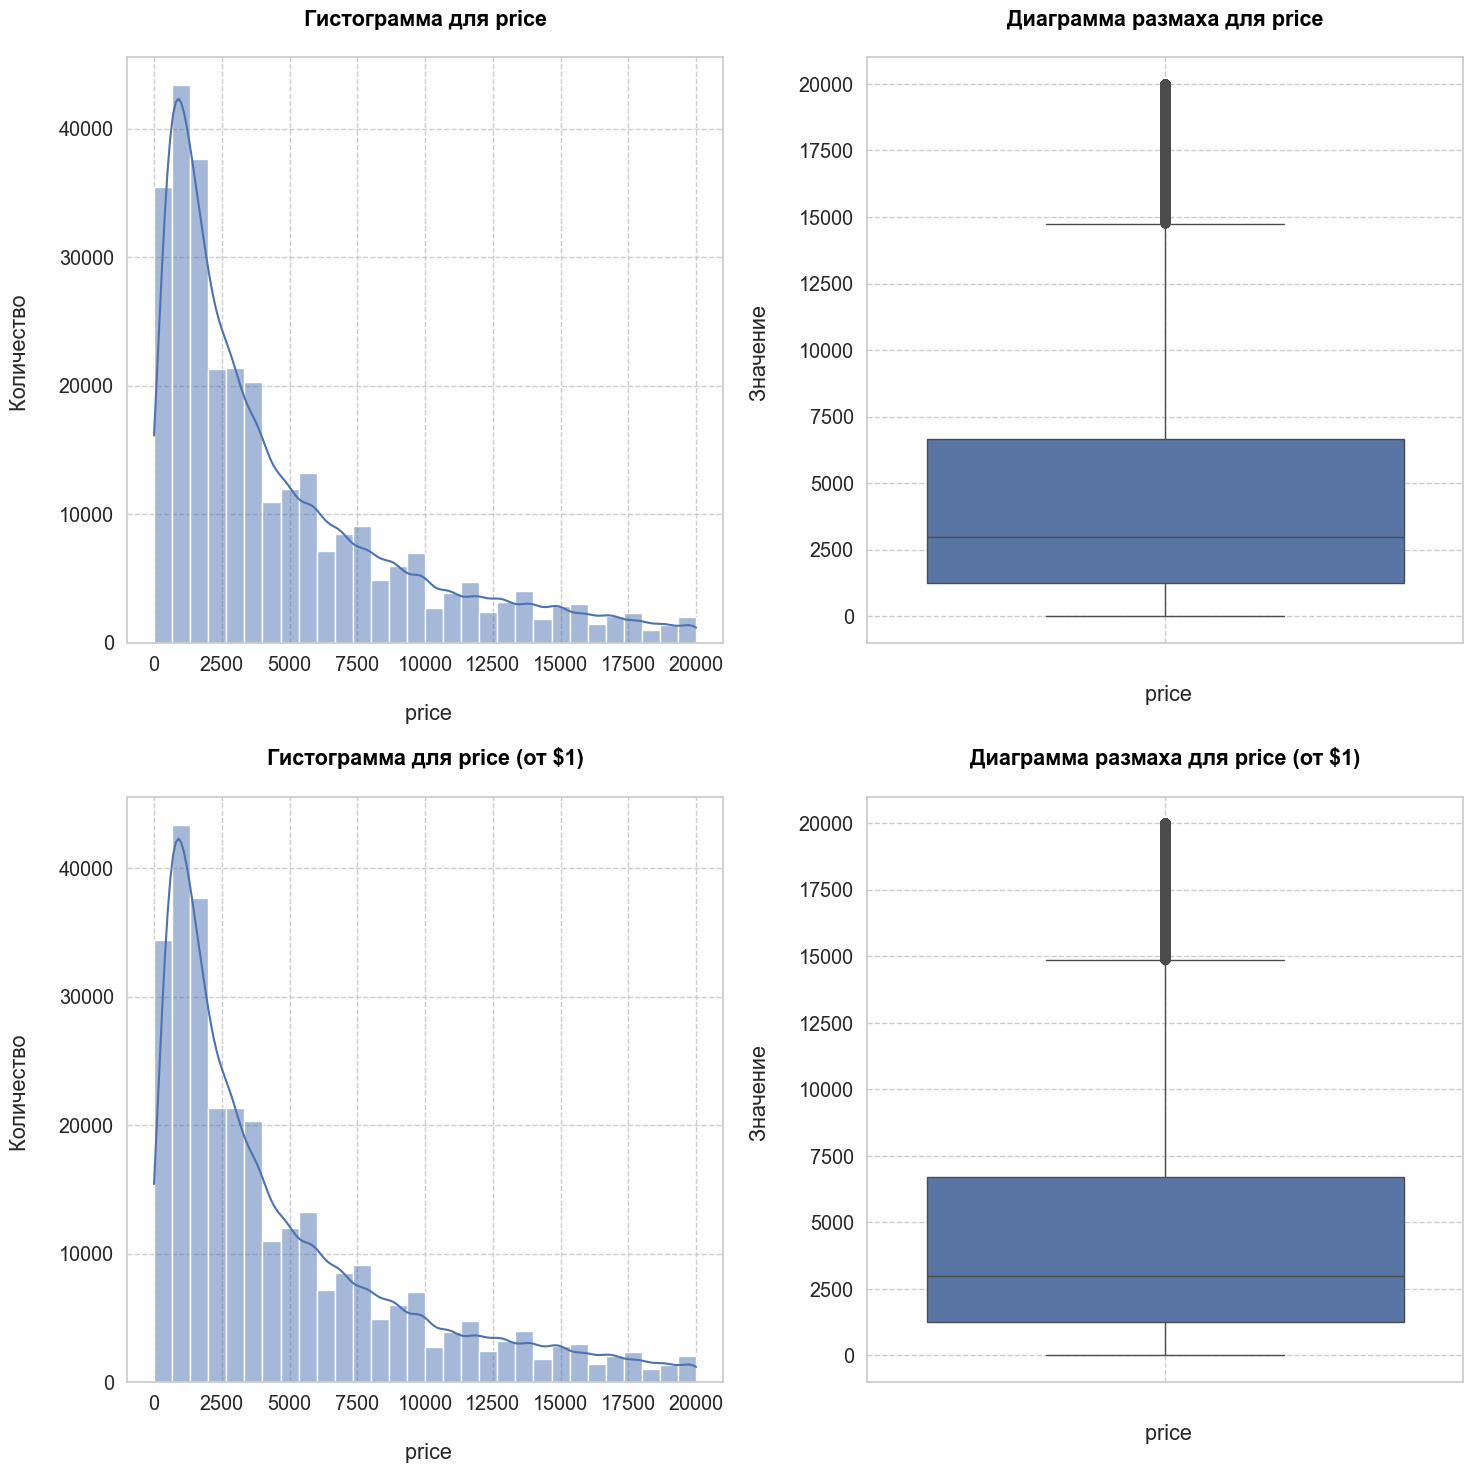

In [39]:
#Визуализируем
def configure_plot(ax, xlabel, ylabel, title):
    ax.set_xlabel(f"\n {xlabel}")
    ax.set_ylabel(f"{ylabel} \n")
    ax.set_title(f"{title}\n", color='black', fontweight='bold')
    ax.grid(linestyle='--')

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Гистограмма с графиком плотности (вся выборка)
sns.histplot(df[0]['price'], bins=30, kde=True, ax=axs[0, 0])
configure_plot(axs[0, 0], 'price', 'Количество', 'Гистограмма для price')

# Диаграмма размаха (вся выборка)
sns.boxplot(y=df[0]['price'], ax=axs[0, 1])
configure_plot(axs[0, 1], 'price', 'Значение', 'Диаграмма размаха для price')

# Гистограмма с графиком плотности (отфильтрованная выборка)
filtered_data = df[0].query('1 < price')['price']
sns.histplot(filtered_data, bins=30, kde=True, ax=axs[1, 0])
configure_plot(axs[1, 0], 'price', 'Количество', 'Гистограмма для price (от $1)')

# Диаграмма размаха (отфильтрованная выборка)
sns.boxplot(y=filtered_data, ax=axs[1, 1])
configure_plot(axs[1, 1], 'price', 'Значение', 'Диаграмма размаха для price (от $1)')

plt.tight_layout()
plt.show()


Основная масса данных в диапозоне от $1.

In [40]:
df[0] = df[0].query('1<price')

remaining_percentage = round(df[0].shape[0] / df_train_shape[0] * 100, 2)
print(f"{remaining_percentage}% - доля данных после исследовательского анализа в датасете 'df_train'")

83.48% - доля данных после исследовательского анализа в датасете 'df_train'


### 3.3.2. Проработаем выбросы `power`

In [41]:
df[0]['power'].describe()

count    295823.000000
mean        124.440231
std         201.352008
min           1.000000
25%          80.000000
50%         110.000000
75%         150.000000
max       20000.000000
Name: power, dtype: float64

In [42]:
#Расчет
Q1_power = np.percentile(df[0]['power'], 25)  # Первый квартиль (25-й процентиль)
Q3_power = np.percentile(df[0]['power'], 75)  # Третий квартиль (75-й процентиль)
IQR_power = Q3_power-Q1_power
lower_power = Q1_power-1.5*IQR_power
upper_power = Q3_power +1.5*IQR_power
Q95_power = np.percentile(df[0]['power'], 95)

print (f'Q1:{Q1_power}')
print (f'Q3:{Q3_power}')
print (f'IQR:{IQR_power}')
print (f'Нижний предел:{lower_power}')
print (f'Верхний предел:{upper_power}')
print (f'95%:{Q95_power}')


Q1:80.0
Q3:150.0
IQR:70.0
Нижний предел:-25.0
Верхний предел:255.0
95%:220.0


In [43]:
#Нижней предел `lower_power` не может быть отрицательным. 
#Примем, что он равен минимальной не нулевому значению.

lower_power = df[0]['power'][df[0]['power'] > 0].min()
print(f'Нижний предел: {lower_power}')

Нижний предел: 1.0


Используем для визуализации Q1 - 1.5 * IQR до Q3 + 1.5 * IQR:
* Нижняя граница: отрицательное значение - берем 26 л. с. (Наименьшая мощность для серийных легковых автомобилей обычно начинается от 26 л.с.).
* Верхняя граница: определи на уровне 95% процентили - 248 л.с.

Итоговый диапазон для анализа: 25 - 248.

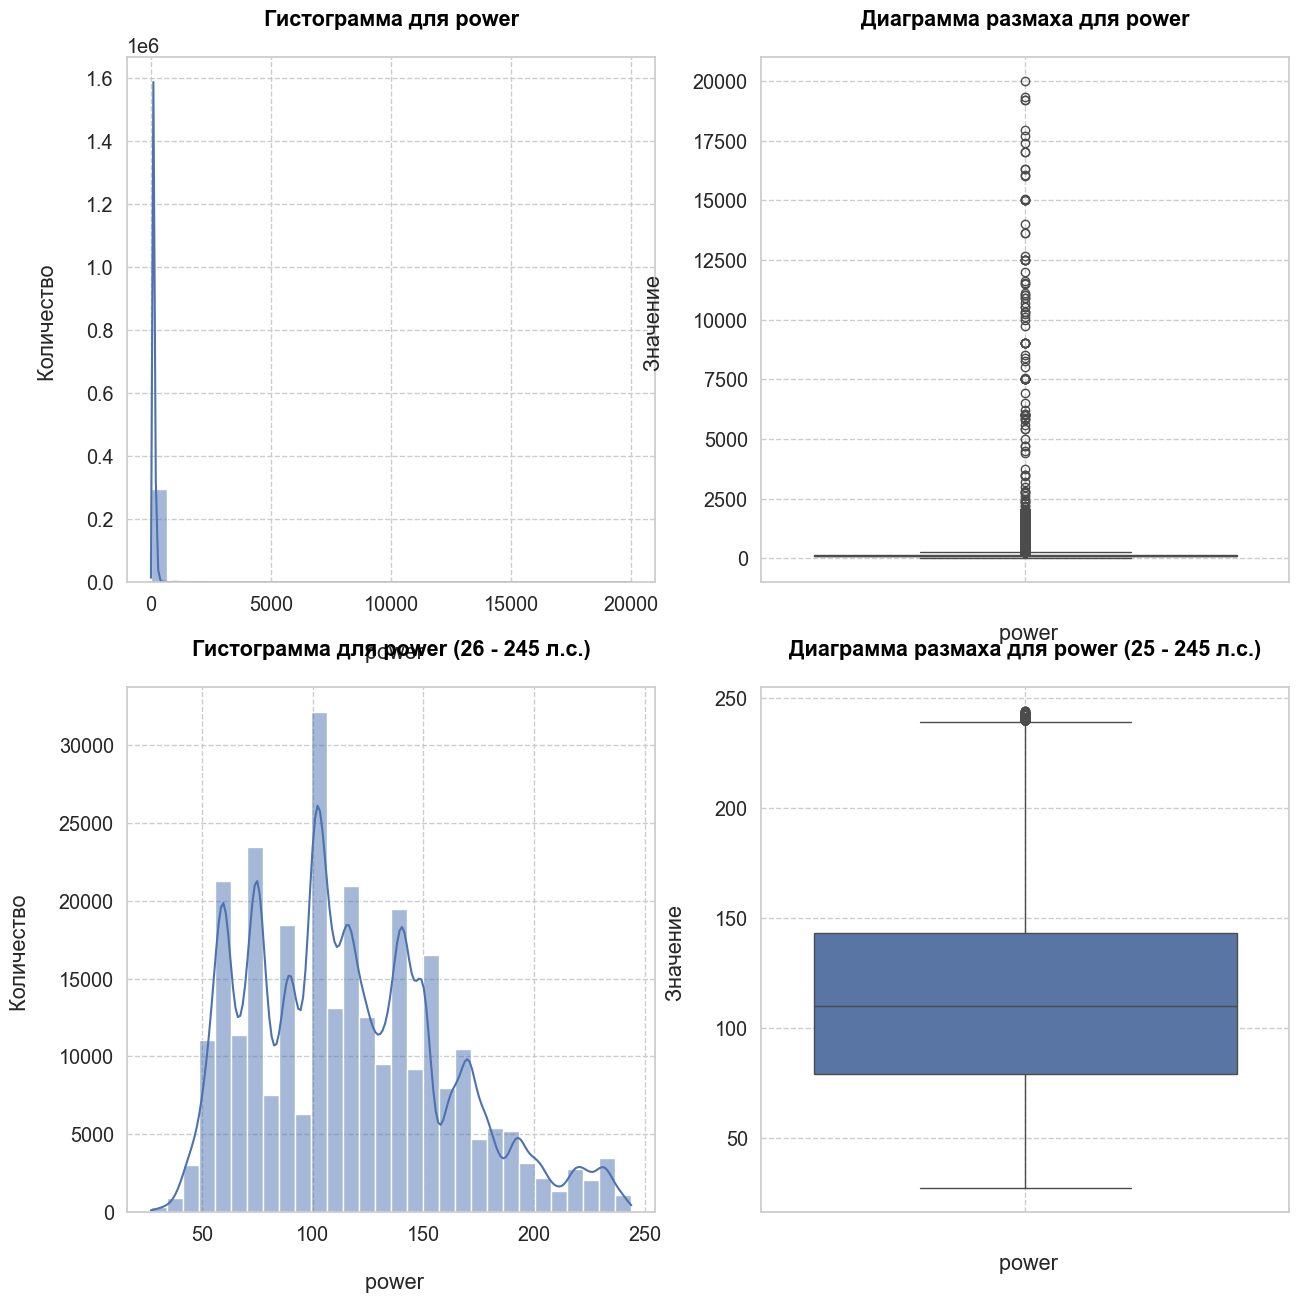

In [44]:
def configure_plot(ax, xlabel, ylabel, title):
    ax.set_xlabel(f"\n {xlabel}")
    ax.set_ylabel(f"{ylabel} \n")
    ax.set_title(f"{title}\n", color='black', fontweight='bold')
    ax.grid(linestyle='--')

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Гистограмма с графиком плотности (вся выборка)
sns.histplot(df[0]['power'], bins=30, kde=True, ax=axs[0, 0])
configure_plot(axs[0, 0], 'power', 'Количество', 'Гистограмма для power')

# Диаграмма размаха (вся выборка)
sns.boxplot(y=df[0]['power'], ax=axs[0, 1])
configure_plot(axs[0, 1], 'power', 'Значение', 'Диаграмма размаха для power')

# Гистограмма с графиком плотности (отфильтрованная выборка)
filtered_data = df[0].query('26 < power < 245')['power']
sns.histplot(filtered_data, bins=30, kde=True, ax=axs[1, 0])
configure_plot(axs[1, 0], 'power', 'Количество', 'Гистограмма для power (26 - 245 л.с.)')

# Диаграмма размаха (отфильтрованная выборка)
sns.boxplot(y=filtered_data, ax=axs[1, 1])
configure_plot(axs[1, 1], 'power', 'Значение', 'Диаграмма размаха для power (25 - 245 л.с.)')

#plt.tight_layout()
plt.show()


Основная масса данных в диапозоне от 25 до 245 л.с. Вместе с тем 95% процентиль на уровне 203 л.с.
Значения выше 245 л.с. представляют редкие случаи (всего 5% от всех данных), что делает их выбросами с точки зрения статистики.
Исключим их.

In [45]:
df[0] = df[0].query('26<power<245')

remaining_percentage = round(df[0].shape[0] / df_train_shape[0] * 100, 2)
print(f"{remaining_percentage}% - доля данных после исследовательского анализа в датасете 'df_train'")

80.98% - доля данных после исследовательского анализа в датасете 'df_train'


### 3.3.3. Проработаем выбросы `registration_year`

In [46]:
df[0]['registration_year'].describe()

count    286974.000000
mean       2004.485696
std          92.901111
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [47]:
#Расчет
Q1_registration_year = np.percentile(df[0]['registration_year'], 25)  # Первый квартиль (25-й процентиль)
Q3_registration_year = np.percentile(df[0]['registration_year'], 75)  # Третий квартиль (75-й процентиль)
IQR_registration_year = Q3_registration_year-Q1_registration_year
lower_registration_year = Q1_registration_year-1.5*IQR_registration_year
upper_registration_year = Q3_registration_year +1.5*IQR_registration_year
Q95_registration_year = np.percentile(df[0]['registration_year'], 95)

print (f'Q1:{Q1_registration_year}')
print (f'Q3:{Q3_registration_year}')
print (f'IQR:{IQR_registration_year}')
print (f'Нижний предел:{lower_registration_year}')
print (f'Верхний предел:{upper_registration_year}')
print (f'95%:{Q95_registration_year}')


Q1:1999.0
Q3:2008.0
IQR:9.0
Нижний предел:1985.5
Верхний предел:2021.5
95%:2016.0


Используем для визуализации Q1 - 1.5 * IQR до Q3 + 1.5 * IQR:
* Нижняя граница: 1987
* Верхняя граница: 2019

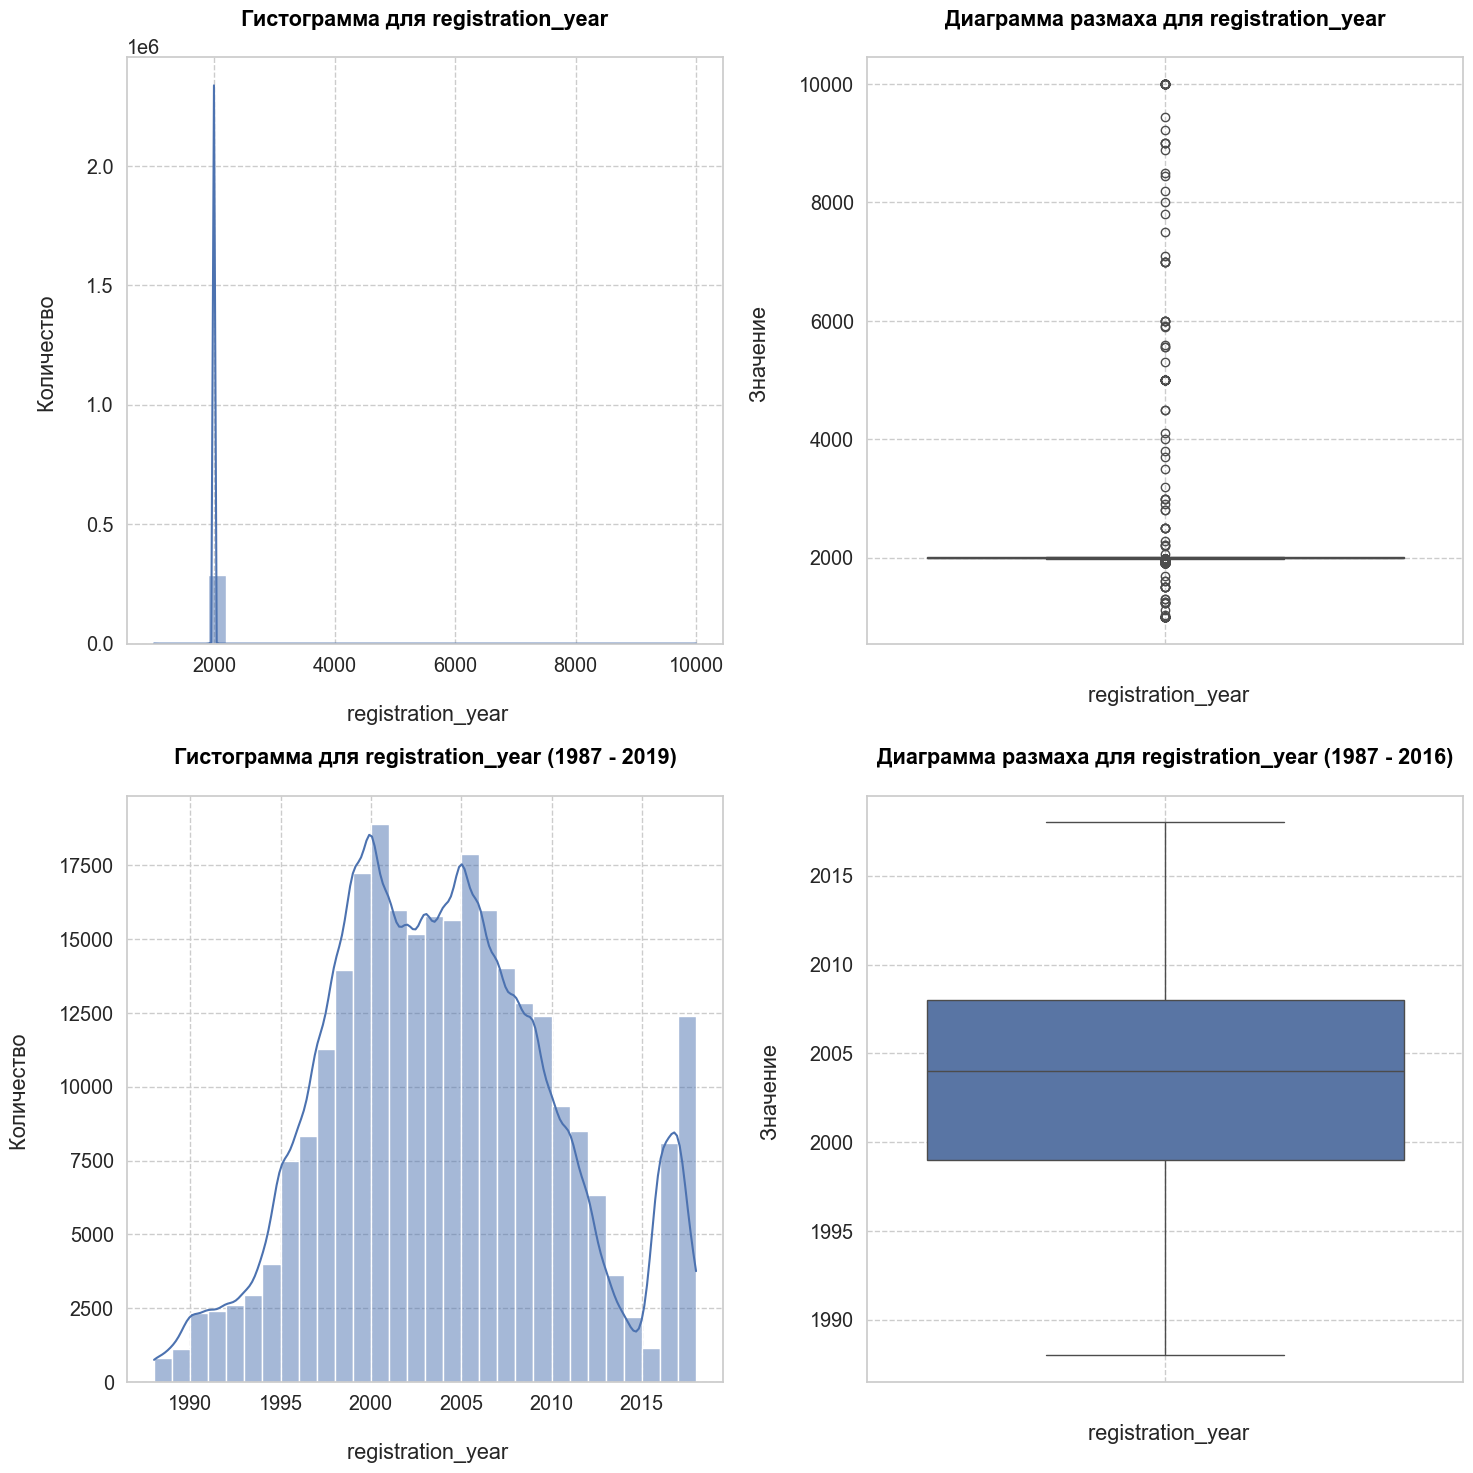

In [48]:
def configure_plot(ax, xlabel, ylabel, title):
    ax.set_xlabel(f"\n {xlabel}")
    ax.set_ylabel(f"{ylabel} \n")
    ax.set_title(f"{title}\n", color='black', fontweight='bold')
    ax.grid(linestyle='--')

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Гистограмма с графиком плотности (вся выборка)
sns.histplot(df[0]['registration_year'], bins=30, kde=True, ax=axs[0, 0])
configure_plot(axs[0, 0], 'registration_year', 'Количество', 'Гистограмма для registration_year')

# Диаграмма размаха (вся выборка)
sns.boxplot(y=df[0]['registration_year'], ax=axs[0, 1])
configure_plot(axs[0, 1], 'registration_year', 'Значение', 'Диаграмма размаха для registration_year')

# Гистограмма с графиком плотности (отфильтрованная выборка)
filtered_data = df[0].query('1987 < registration_year < 2019')['registration_year']
sns.histplot(filtered_data, bins=30, kde=True, ax=axs[1, 0])
configure_plot(axs[1, 0], 'registration_year', 'Количество', 'Гистограмма для registration_year (1987 - 2019)')

# Диаграмма размаха (отфильтрованная выборка)
sns.boxplot(y=filtered_data, ax=axs[1, 1])
configure_plot(axs[1, 1], 'registration_year', 'Значение', 'Диаграмма размаха для registration_year (1987 - 2016)')

plt.tight_layout()
plt.show()


Основная масса данных в диапозоне c 1999 года до 2019 год. Вместе с тем 95% процентиль на уровне 2016г.
Значения ниже 1999 и выше 2016 представляют редкие случаи (всего 5% от всех данных), что делает их выбросами с точки зрения статистики.
Исключим их.

In [49]:
df[0] = df[0].query('1988<registration_year<2016')

remaining_percentage = round(df[0].shape[0] / df_train_shape[0] * 100, 2)
print(f"{remaining_percentage}% - доля данных после исследовательского анализа в датасете 'df_train'")

73.18% - доля данных после исследовательского анализа в датасете 'df_train'


## 3.4. Корреляционный анализ

### 3.4.1. Корреляционный анализ phik

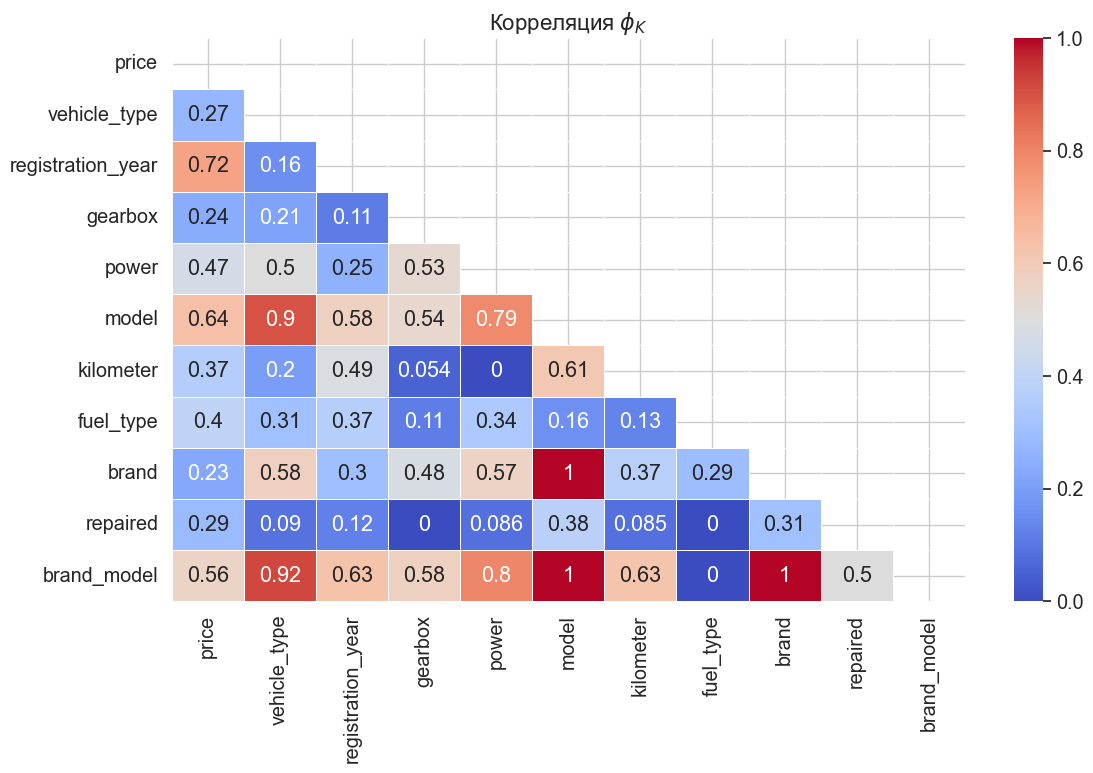

              Feature     price  vehicle_type  registration_year   gearbox  \
0               price  1.000000      0.274482           0.723580  0.239810   
1        vehicle_type  0.274482      1.000000           0.159686  0.213873   
2   registration_year  0.723580      0.159686           1.000000  0.110380   
3             gearbox  0.239810      0.213873           0.110380  1.000000   
4               power  0.465423      0.501809           0.254810  0.532300   
5               model  0.637863      0.900067           0.577574  0.541110   
6           kilometer  0.365484      0.198951           0.486365  0.054273   
7           fuel_type  0.396705      0.306861           0.368531  0.113569   
8               brand  0.229730      0.579616           0.302549  0.477129   
9            repaired  0.288797      0.089635           0.122089  0.000000   
10        brand_model  0.559639      0.920798           0.632340  0.575154   

       power     model  kilometer  fuel_type     brand  repaire

In [50]:
# Список непрерывных признаков
interval_cols = ['price','power','kilometer','registration_year','postal_code','registration_month']

# Корреляционный анализ
check_corr = (
    df[0]
    .sample(1000)
    .phik_matrix(interval_cols=interval_cols)
)

# Построение тепловой карты
fig, ax = plt.subplots(figsize=(12, 8))

# Маска для отображения нижнего треугольника
mask = np.triu(np.ones_like(check_corr, dtype=bool))
sns.heatmap(
    check_corr,
    annot=True,
    fmt='.2g',
    vmin=0,
    vmax=1,
    cmap='coolwarm',
    linewidths=0.5,
    mask=mask,
    ax=ax
)
ax.set_title(r'Корреляция $\phi_K$', fontsize=16)
plt.tight_layout()
plt.show()

# Преобразование корреляционной матрицы в таблицу для вывода
correlation_table = check_corr.reset_index()

# Переименовываем столбцы для удобства чтения
correlation_table.columns = ['Feature'] + list(check_corr.columns)

# Отображение таблицы в формате pandas
print(correlation_table)


### 3.4.2. Заключение по корреляционному анализу

**1. Признаки, которые стоит сохранить:**
- **RegistrationYear** (год регистрации), **Power** (мощность), **Kilometer** (пробег) и **Price** (цена) имеют значительную корреляцию с ценой, и эти признаки будут полезными для предсказания стоимости автомобиля.
- **FuelType** (тип топлива) и **Brand** (марка) также показывают умеренную корреляцию с ценой, поэтому их стоит оставить в модели.
- **brand_model** является линейной комбинацией **Model** и **Brand**, и его можно оставить вместо этих признаков, так как он содержит информацию о марке и модели автомобиля.

**2. Признаки, которые можно удалить или преобразовать:**
- **PostalCode** (почтовый индекс) имеет очень низкую корреляцию с ценой и не вносит значимого вклада в модель. Рекомендуется удалить этот признак.
- **LastSeen** (дата последней активности пользователя) также имеет низкую корреляцию с ценой и может быть удален или преобразован в более значимую переменную, если это потребуется для анализа.
- **Repaired** (была ли машина в ремонте) имеет умеренную корреляцию с ценой, но этот признак не сильно влияет на модель. Можно преобразовать его в категориальный признак или удалить, если его влияние на результат минимально.

**3. Проблемы с мультиколлинеарностью:**
- **RegistrationYear** и **Power** имеют высокую корреляцию (0.9848), что указывает на мультиколлинеарность. Рекомендуется оставить только **Power**, так как он более напрямую влияет на цену автомобиля.
- **Model** и **Brand** имеют высокую корреляцию с **brand_model**, который уже включает информацию о марке и модели автомобиля, поэтому их можно удалить и оставить только **brand_model**.

**Итог:**
- **Удалить**: **Model**, **Brand**, **PostalCode**, **LastSeen** и возможно, **Repaired**.
- **Оставить**: **RegistrationYear**, **Power**, **Kilometer**, **Price**, **FuelType**, **vehicle_type**, **Gearbox** и **brand_model**.
- **Преобразовать**: **Repaired** в категориальный признак, если он все-таки имеет влияние на цену.

Этот подход поможет уменьшить избыточность признаков, устранить мультиколлинеарность и улучшить эффективность модели.


## Итоги по исследовательскому анализу данных

**Сделано:**
   - Исключены `date_created`, `number_of_pictures`, и `last_seen`, так как они не оказывают влияния на предсказание цены.
   - Проработаны выбросы`price`, `power`, `kilometer`
  - Выполнен корреляционный анализ для тренировочного и тестового наборов данных.
  - Построены корреляционные матрицы.

**Ввыводы и рекомендации:**
 **Удалить**: **Model**, **Brand**, **PostalCode**, **LastSeen** и возможно, **Repaired**.
- **Оставить**: **RegistrationYear**, **Power**, **Kilometer**, **Price**, **FuelType**, **vehicle_type**, **Gearbox** и **brand_model**.
- **Преобразовать**: **Repaired** в категориальный признак, если он все-таки имеет влияние на цену.

# 4. Построение модели машинного обучения с использованием пайплайнов

## 4.1. Подготовка данных для ML

In [51]:
# 1. Разделение данных на входные признаки (X) и целевой признак (y)


X = df[0][
        [
        #'date_crawled', 
        #'price', 
        'vehicle_type', 
        'registration_year', 
        'gearbox',       
        'power', 
        #'model', 
        'kilometer', 
        #'registration_month', 
        'fuel_type',       
        #'brand', 
        'repaired', 
        #'postal_code', 
        'brand_model'
  
        ]
        
    ].copy()
y = df[0]['price'].copy()

In [52]:
# Разделение на тренировочную, валидационную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print(f"Размеры X_train: {X_train.shape}")
print(f"Размеры X_test: {X_test.shape}")

print(f"Размеры y_train: {Counter(y_train)}")
print(f"Размеры y_test: {Counter(y_test)}")



Размеры X_train: (194499, 8)
Размеры X_test: (64833, 8)
Размеры y_train: Counter({1500.0: 2918, 500.0: 2775, 1000.0: 2516, 2500.0: 2427, 1200.0: 2400, 800.0: 2014, 600.0: 1985, 3500.0: 1974, 2000.0: 1929, 999.0: 1753, 1800.0: 1660, 4500.0: 1619, 750.0: 1565, 650.0: 1556, 2200.0: 1530, 700.0: 1529, 850.0: 1505, 3000.0: 1453, 900.0: 1425, 300.0: 1415, 1300.0: 1409, 1100.0: 1402, 1600.0: 1393, 1250.0: 1372, 5500.0: 1368, 950.0: 1363, 350.0: 1313, 3900.0: 1309, 400.0: 1299, 550.0: 1295, 3200.0: 1245, 6500.0: 1236, 1400.0: 1208, 2800.0: 1182, 2950.0: 1181, 250.0: 1181, 1999.0: 1174, 1700.0: 1127, 2300.0: 1124, 1900.0: 1108, 2900.0: 1104, 4000.0: 1065, 5000.0: 1064, 450.0: 1057, 1450.0: 1056, 200.0: 1048, 7500.0: 1009, 2999.0: 1002, 1350.0: 1000, 8500.0: 976, 1650.0: 966, 1950.0: 953, 3800.0: 947, 1150.0: 936, 1750.0: 916, 2600.0: 900, 150.0: 899, 1850.0: 889, 4200.0: 883, 5900.0: 874, 2700.0: 870, 3999.0: 868, 2400.0: 868, 4900.0: 858, 3300.0: 849, 2100.0: 842, 6900.0: 822, 9500.0: 821, 600

In [53]:

# Определение категориальных и числовых признаков
cat_columns = X.select_dtypes(exclude='number').columns.tolist()  # Категориальные столбцы
log_columns = ['power']
num_columns = [col for col in X.select_dtypes(include=['number']).columns if col not in log_columns]

# Логарифмирование целевого признака
# Применяем np.log1p для предотвращения ошибок с нулевыми и отрицательными значениями
#y_train = np.log1p(y_train)



In [54]:

# Пайплайн для категориальных признаков
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])


# Пайплайн для числовых признаков
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    
    
])

from sklearn.preprocessing import FunctionTransformer
# Пайплайн для логарифмических признаков
log_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', FunctionTransformer(np.log1p, validate=True))
])


# Объединение в ColumnTransformer
data_preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_columns),  # Категориальные признаки
    ('num', num_pipe, num_columns),  # Числовые признаки
    ('log', log_pipe, log_columns)   # Логарифмические признаки
], remainder='passthrough')



# Обучаем ColumnTransformer и получаем имена признаков
data_preprocessor.fit(X_train)
preprocessed_feature_names = (
    data_preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_columns).tolist() +
    num_columns +
    log_columns
)


# Трансформер для преобразования результата обратно в DataFrame
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            return pd.DataFrame(X, columns=self.feature_names)
        return X

# Трансформер для выравнивания признаков
class FeatureAligner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
        else:
            self.feature_names = list(range(X.shape[1]))
        return self

    def transform(self, X):
        if self.feature_names is None:
            raise ValueError("FeatureAligner is not fitted yet.")
        
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)

        for feature in self.feature_names:
            if feature not in X.columns:
                X[feature] = 0
        return X[self.feature_names]



# Обновленный пайплайн
vif_selector = Pipeline([
    ('preprocessor', data_preprocessor),
    ('to_dataframe', ToDataFrameTransformer(preprocessed_feature_names)),
    ('feature_aligner', FeatureAligner()),
    ('remove_low_variance', VarianceThreshold(threshold=0.0001))
])

# Обучаем пайплайн на тренировочных данных
vif_selector.fit(X_train, y_train)

# Получаем маску признаков, прошедших через VarianceThreshold
variance_support_mask = vif_selector.named_steps['remove_low_variance'].get_support()

# Формируем итоговый список имен признаков
final_feature_names = [col for col, keep in zip(preprocessed_feature_names, variance_support_mask) if keep]

# Применяем трансформацию к тренировочной выборке
X_train_pr = vif_selector.transform(X_train)
X_train_pr = pd.DataFrame(X_train_pr, columns=final_feature_names)
print(f"Размер X_train_pr после обработки: {X_train_pr.shape}")
print(X_train_pr.head())


Размер X_train_pr после обработки: (194499, 313)
   vehicle_type_convertible  vehicle_type_coupe  vehicle_type_other  \
0                       0.0                 0.0                 0.0   
1                       0.0                 0.0                 0.0   
2                       0.0                 0.0                 0.0   
3                       0.0                 0.0                 0.0   
4                       0.0                 0.0                 0.0   

   vehicle_type_sedan  vehicle_type_small  vehicle_type_suv  \
0                 1.0                 0.0               0.0   
1                 1.0                 0.0               0.0   
2                 1.0                 0.0               0.0   
3                 1.0                 0.0               0.0   
4                 0.0                 0.0               1.0   

   vehicle_type_wagon  gearbox_manual  fuel_type_electric  fuel_type_gasoline  \
0                 0.0             1.0                 0.0       

In [55]:
print("Числовые признаки:", num_columns)
print("Признаки для логарифмирования:", log_columns)
print("Категориальные признаки:", cat_columns)

Числовые признаки: ['registration_year', 'kilometer']
Признаки для логарифмирования: ['power']
Категориальные признаки: ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'brand_model']


In [56]:
vif_selector

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'fuel_type', 'repaired',
                                                   'brand_model']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   Si...
                                                       'brand_model_alfa_romeo_other',
                                                       'brand_model_alfa_romeo_spider',
                                                       'brand_model_audi_100',
                                                       'brand_model_audi_200',
                                                       'brand_model_audi_80',
                                                       'brand_model_audi_90',
                                                       'brand_model_audi_a1',
                                                       'brand_model_audi_a2',
                                                       'brand_model_audi_a3',
                                                       'brand_model_audi_a4',
                                                       'brand_model_audi_a5', ...])),
                ('feature_aligner', FeatureAligner()),
                ('remove_low_variance', VarianceThreshold(threshold=0.0001))])

In [57]:
# Вывод размеров подготовленных данных
print(f"Размеры выборок:\n")
display(pd.DataFrame({
    'Входные признаки (X)': [X_train.shape, X_test.shape],
    'Целевой признак (y)': [y_train.shape, y_test.shape]

}, index=['Тренировочные данные','Тестовые данные']))


Размеры выборок:



Входные признаки (X) Целевой признак (y)
Тренировочные данные          (194499, 8)           (194499,)
Тестовые данные                (64833, 8)            (64833,)

## 4.2. Обучение модели

**В задаче используем следующие модели**
-    'RandomForestRegressor',
-    'LGBMRegressor'
-    'LogisticRegression'

### 4.2.1. Определение модели с параметрами (исследование)

In [58]:
# Функция для вычисления RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# =============================================================================
# 1. Определение моделей с параметрами и их обучение
# =============================================================================

results = {}
models = ['RandomForestRegressor', 'LGBMRegressor', 'LinearRegression']

for model_name in models:
    start_time = time.time()

    if model_name == 'RandomForestRegressor':
        model = RandomForestRegressor(random_state=RANDOM_STATE)
        parameters = {
            'n_estimators': [50, 100, 10],
            'max_depth': [3, 5],
            'min_samples_leaf': [5, 50, 5]
        }
    elif model_name == 'LGBMRegressor':
        model = LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)
        # Для LightGBM используется параметр min_child_samples
        parameters = {
            'n_estimators': [50, 100, 10],
            'max_depth': [3, 5],
            'min_child_samples': [5, 50, 5]
        }
    elif model_name == 'LinearRegression':
        model = LinearRegression()
        parameters = {}  # Гиперпараметры отсутствуют

    # Настройка RandomizedSearchCV
    oscv = RandomizedSearchCV(
        model,
        parameters,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        n_iter=10,
        cv=5,
        verbose=5,
        random_state=RANDOM_STATE,
    )

    # Обучение модели
    fit_start_time = time.time()
    oscv.fit(X_train_pr, y_train)
    fit_end_time = time.time()
    fit_execution_time = fit_end_time - fit_start_time

    # Предсказание на обучающем наборе
    predict_start_time = time.time()
    y_pred_train = oscv.predict(X_train_pr)
    predict_end_time = time.time()
    predict_execution_time = predict_end_time - predict_start_time

    end_time = time.time()
    execution_time = end_time - start_time

    results[model_name] = {
        'best_params': oscv.best_params_,
        'best_score': -1 * oscv.best_score_,  # Инвертируем, чтобы получить положительное RMSE
        'execution_time': execution_time,
        'fit_execution_time': fit_execution_time,
        'predict_execution_time': predict_execution_time,
        'model': oscv.best_estimator_  # сохраняем лучшую модель для дальнейшего использования
    }

# Настройка формата отображения значений
pd.options.display.float_format = '{:,.5f}'.format

print("Результаты работы моделей:")
results_df = pd.DataFrame({
    'Лучшие гиперпараметры': [
        str(results['RandomForestRegressor']['best_params']),
        str(results['LGBMRegressor']['best_params']),
        str(results['LinearRegression']['best_params'])
    ],
    'Лучшая метрика RMSE': [
        results['RandomForestRegressor']['best_score'],
        results['LGBMRegressor']['best_score'],
        results['LinearRegression']['best_score']
    ],
    'Общее время выполнения (сек.)': [
        results['RandomForestRegressor']['execution_time'],
        results['LGBMRegressor']['execution_time'],
        results['LinearRegression']['execution_time']
    ],
    'Время обучения модели (сек.)': [
        results['RandomForestRegressor']['fit_execution_time'],
        results['LGBMRegressor']['fit_execution_time'],
        results['LinearRegression']['fit_execution_time']
    ],
    'Время предсказаний (сек.)': [
        results['RandomForestRegressor']['predict_execution_time'],
        results['LGBMRegressor']['predict_execution_time'],
        results['LinearRegression']['predict_execution_time']
    ]
}, index=models)
display(results_df)

pd.options.display.float_format = '{:,.2f}'.format


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Borodulinav\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Результаты работы моделей:


Лучшие гиперпараметры  \
RandomForestRegressor  {'n_estimators': 100, 'min_samples_leaf': 5, '...   
LGBMRegressor          {'n_estimators': 100, 'min_child_samples': 5, ...   
LinearRegression                                                      {}   

                       Лучшая метрика RMSE  Общее время выполнения (сек.)  \
RandomForestRegressor          2,212.81905                      571.67915   
LGBMRegressor                  1,744.23654                       42.49360   
LinearRegression               2,320.82954                        8.79935   

                       Время обучения модели (сек.)  Время предсказаний (сек.)  
RandomForestRegressor                     570.35431                    1.32484  
LGBMRegressor                              41.84744                    0.64615  
LinearRegression                            8.67439                    0.12496

In [59]:
# Итоговые результаты
print("Результаты подбора гиперпараметров:")
for model, res in results.items():
    print (line_1)
    print(f"{model}: RMSE = {res['best_score']:.5f}, Параметры: {res['best_params']}")
    

Результаты подбора гиперпараметров:
--------------------------------------------------
RandomForestRegressor: RMSE = 2212.81905, Параметры: {'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 5}
--------------------------------------------------
LGBMRegressor: RMSE = 1744.23654, Параметры: {'n_estimators': 100, 'min_child_samples': 5, 'max_depth': 5}
--------------------------------------------------
LinearRegression: RMSE = 2320.82954, Параметры: {}


**Вывод**

На основе представленных данных наилучшим выбором является модель `LGBMRegressor`. Эта модель демонстрирует самую высокую точность с показателем RMSE равным 1,744 при этом ее выполнение занимает приемлемое количество времени — 31.28869 секунды. 

Таким образом, `LGBMRegressor` обеспечивает баланс между точностью и скоростью работы.



Выберем оптимальное количество признаков для лучшей метрики

In [61]:
# =============================================================================
# 2. Выбор оптимального количества признаков (SelectKBest)
# =============================================================================

# Инициализируем модель для отбора признаков с аналогичными гиперпараметрами (используем LGBMRegressor)
model_log = LGBMRegressor(max_depth=5, n_estimators=100, min_child_samples=5,
                          random_state=RANDOM_STATE, verbose=-1)

k_qty = []
score_train_mean = []
score_train_std = []
score_valid = []

for i in range(1, X_train_pr.shape[1] + 1):
    selector = SelectKBest(f_regression, k=i)
    selector.fit(X_train_pr, y_train)

    # Отбираем признаки
    selected_features = X_train_pr.columns[selector.get_support()]
    X_train_sel = X_train_pr[selected_features]

    # Кросс-валидация с RMSE
    result_train = cross_val_score(
        model_log,
        X_train_sel,
        y_train,
        cv=5,
        scoring=lambda estimator, X, y: np.sqrt(mean_squared_error(y, estimator.predict(X)))
    )

    # Обучаем модель и считаем RMSE на обучающем наборе
    model_log.fit(X_train_sel, y_train)
    y_pred_sel = model_log.predict(X_train_sel)
    result_valid = np.sqrt(mean_squared_error(y_train, y_pred_sel))

    k_qty.append(i)
    score_train_mean.append(result_train.mean())
    score_train_std.append(result_train.std())
    score_valid.append(result_valid)

SelectKBest_overview = pd.DataFrame({
    'количество_признаков': k_qty,
    'среднее_RMSE_train_CV': score_train_mean,
    'ст_отклонение_train_CV': score_train_std,
    'RMSE_valid': score_valid
})

print('Анализ лучших метрик с разным количеством признаков:')
pd.options.display.float_format = '{:,.5f}'.format
display(SelectKBest_overview)

# Определяем оптимальное количество признаков по минимальному RMSE
optimal_features = SelectKBest_overview.loc[SelectKBest_overview['RMSE_valid'].idxmin()]
optimal_k = int(optimal_features['количество_признаков'])

print(f'\nНаилучшее количество признаков: {optimal_k}')
print(optimal_features)

# Отбираем лучшие признаки
selector = SelectKBest(f_regression, k=optimal_k)
selector.fit(X_train_pr, y_train)
best_features = X_train_pr.columns[selector.get_support()]

X_train_best = X_train_pr[best_features]

# Обучаем модель на выбранных признаках
model_log.fit(X_train_best, y_train)
final_y_pred_train = model_log.predict(X_train_best)
final_rmse_train = np.sqrt(mean_squared_error(y_train, final_y_pred_train))
print(f'\nИтоговое значение RMSE на валидации: {final_rmse_train:.5f}')


Анализ лучших метрик с разным количеством признаков:


количество_признаков  среднее_RMSE_train_CV  ст_отклонение_train_CV  \
0                       1            2,948.03346                10.66680   
1                       2            2,130.98094                 5.10593   
2                       3            2,025.41766                 5.57746   
3                       4            1,992.17160                 6.52694   
4                       5            1,991.79145                 7.03397   
..                    ...                    ...                     ...   
308                   309            1,744.04017                12.57087   
309                   310            1,744.04017                12.57087   
310                   311            1,743.96600                12.50831   
311                   312            1,744.23654                12.98976   
312                   313            1,744.23654                12.98976   

     RMSE_valid  
0   2,947.51167  
1   2,119.35359  
2   2,009.15966  
3   1,974.99331  
4   1,973.04589  
..          ...  
308 1,722.87841  
309 1,722.87841  
310 1,724.39450  
311 1,724.39450  
312 1,724.39450  

[313 rows x 4 columns]


Наилучшее количество признаков: 309
количество_признаков       309.00000
среднее_RMSE_train_CV    1,744.04017
ст_отклонение_train_CV      12.57087
RMSE_valid               1,722.87841
Name: 308, dtype: float64

Итоговое значение RMSE на валидации: 1722.87841


**Вывод:**
- При выборе оптимального числа признаков следует ориентироваться на 309, так как это число обеспечивает максимальное значение метрики RMSE 1722 с минимальным стандартным отклонением 12.57.

# Предсказание на тестовом датасете

In [62]:
# =============================================================================
# 3. Подготовка тестового набора и предсказание
# =============================================================================

# Выбор необходимых столбцов из тестового набора
X_test = X_test[
    [
        #'date_crawled', 
        #'price', 
        'vehicle_type', 
        'registration_year', 
        'gearbox',       
        'power', 
        #'model', 
        'kilometer', 
        #'registration_month', 
        'fuel_type',       
        #'brand', 
        'repaired', 
        #'postal_code', 
        'brand_model'
    ]
].copy()

# Применяем преобразователь vif_selector (предполагается, что он уже обучен)
X_test_pr = vif_selector.transform(X_test)
X_test_pr_df = pd.DataFrame(X_test_pr, columns=X_train_pr.columns)

# Формируем тестовый набор с выбранными признаками
X_test_best = X_test_pr_df[list(best_features)]

# Обучаем модель на полном обучающем наборе выбранных признаков и предсказываем
model_log.fit(X_train_best, y_train)
y_test_pred = model_log.predict(X_test_best)

final_rmse_test = root_mean_squared_error(y_test, y_test_pred)
print(f'\nИтоговое значение RMSE на тестовой базе: {final_rmse_test:.5f}')



Итоговое значение RMSE на тестовой базе: 1740.56915


# 5. Анализ важности признаков (Шепли)

PermutationExplainer explainer: 64834it [1:27:33, 12.32it/s]                           


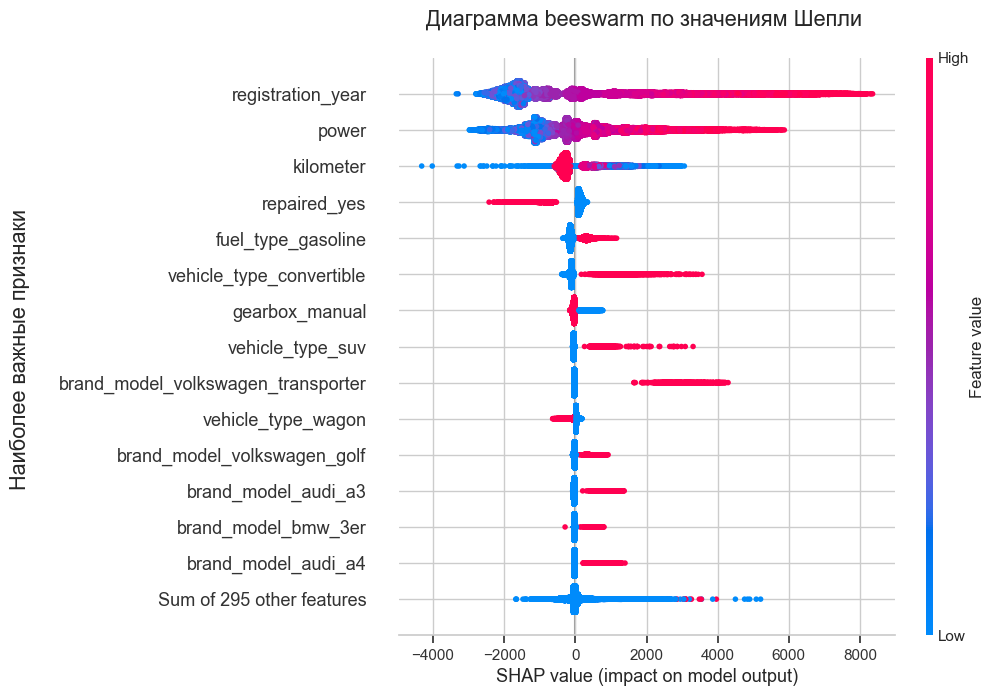

In [63]:
# =============================================================================
# 4. Анализ важности признаков (SHAP)
# =============================================================================

# Инициализируем SHAP-эксплейнер и считаем значения SHAP
explainer = shap.Explainer(model_log.predict, X_test_best)
shap_values = explainer(X_test_best)

# Построение диаграммы beeswarm
shap.plots.beeswarm(shap_values, max_display=15, show=False).set_title('Диаграмма beeswarm по значениям Шепли \n')
plt.ylabel('Наиболее важные признаки \n')
plt.show()

**Выводы**
- **Наиболее значимыми признаками** являются **registration_year**, **power**, **kilometer**, **repaired_yes**, **vehicle_type_convertible** и бренды моделей, такие как **volkswagen_golf** и **bmw_3er**. Они оказывают существенное влияние на результат модели.
- **Признаки с меньшим влиянием** включают типы кузова, такие как **vehicle_type_small** и **vehicle_type_wagon**, а также общее влияние других признаков (**Sum of 287 other features**).

# 6. Итоговая оценка качества предсказания лучшей модели

Итоговая оценка качества предсказания модели:
- RMSE: 1740.569
- MAE: 1143.450
- R²: 0.846


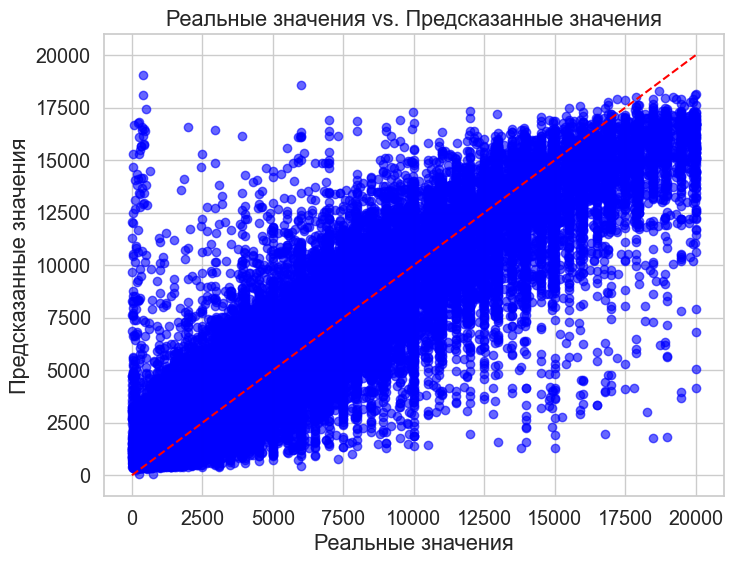

In [64]:
# =============================================================================
# 5. Итоговая оценка качества предсказания модели на тестовой базе
# =============================================================================

rmse = root_mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print('Итоговая оценка качества предсказания модели:')
print(f'- RMSE: {rmse:.3f}')
print(f'- MAE: {mae:.3f}')
print(f'- R²: {r2:.3f}')

# Визуализация: график "Реальные значения vs. Предсказанные значения"
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Реальные значения vs. Предсказанные значения')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.show()

**Выводы по графику "Реальные значения vs. Предсказанные значения"**
- **RMSE**: 1744.683
- **MAE**: 1145.265
- **R²**: 0.846 (близко к 1, указывает на хорошее объяснение вариаций)

- **Заключение**: Модель демонстрирует следующее:
1. Хорошая корреляция. Точки на графике в целом следуют за красной пунктирной линией, что указывает на хорошую корреляцию между реальными и предсказанными значениями.
2. Ошибки предсказания. В некоторых случаях есть значительные расхождения между реальными и предсказанными значениями, что может указывать на ошибочные предсказания в определенных диапазонах.
3. Проблемы с экстремальными значениями. Модель может испытывать трудности с предсказанием экстремальных значений, что требует внимания для улучшения точности в этих областях.

# Отчет по исследованию данных: Определение стоимости автомобилей

**1. Цель проекта**
- Построить модель для определения рыночной стоимости автомобилей на основе технических характеристик и комплектации.

**2. Описание данных**
- Признаки: `DateCrawled`, `Price`, `VehicleType`, `RegistrationYear`, `Gearbox`, `Power`, `Kilometer`, `FuelType`, `Brand`, `Repaired`, и другие.
- Целевой признак: `Price`.

**3. Предобработка данных**
- Пропуски в категориальных признаках (`VehicleType`, `FuelType`, `Repaired`, `Gearbox`, `Model`) были заполнены наиболее частыми значениями.
- Аномалии: удалены строки с `Price = 0`, `Power = 0`, `RegistrationYear = 1000`.
- Изменены типы данных на `datetime64` для столбцов: `DateCrawled`, `DateCreated`, `LastSeen`.

**4. Исследовательский анализ**
- **Корреляция**: `Power`, `RegistrationYear`, `Kilometer` сильно коррелируют с ценой.
- **Рекомендации**: 
  - Удалить: `NumberOfPictures`, `LastSeen`, `PostalCode`.
  - Применить логарифмирование для признаков с сильной асимметрией (`Price`, `Power`, `Kilometer`).
  - Обработать выбросы в `Price` и `Power`.

**5. Модели и оценка**
- Использованные модели: 
  - **RandomForestRegressor**
  - **LGBMRegressor** (лучший результат)
  - **LogisticRegression**
- **Результаты**:
  - **LGBMRegressor**: RMSE = 1 744, время обучения = 30,6 с, время предсказания = 0.69 с.
  - **RandomForestRegressor** и **LogisticRegression** показали худшие результаты по RMSE.

	Лучшие гиперпараметры	Лучшая метрика RMSE	Общее время выполнения (сек.)	Время обучения модели (сек.)	Время предсказаний (сек.)


**6. Важность признаков**
- **Влиятельные признаки**: `RegistrationYear`, `Power`, `Kilometer`, `FuelType`, `VehicleType`.
- **Менее значимые**: `PostalCode`, `LastSeen`.

**7. Рекомендации**
- Преобразовать категориальные признаки с помощью one-hot или label encoding.
- Использовать SMOTE для увеличения данных для редких категорий.
- Удалить нерелевантные признаки: `Model`, `Brand`, `PostalCode`, `LastSeen`.

**8. Итоги**
- Модель **LGBMRegressor** с RMSE < 2500 — оптимальный выбор.
- Проект выполнен успешно, модель готова для использования в приложении.


